## Objective

Since Linear Regression performed better than Decision Tree + pruning, and L2 Lasso allows us to remove non-signaling features, let's take the features from our L2 model, run Linear Regression on them, fine-tune our model, and interpret it.

In [51]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = 20, 5

from helper_functions import dummify_cols_and_baselines, make_alphas, remove_outliers_by_type

In [2]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

## Removing outliers

A standard procedure is to remove values further than 3 standard deviations from the mean. Since I have so many low values and some very high values, I anecdotally think that the low values are very likely to be true, and the high values not so much.

So, I will remove values further than 3 SDs from the median, by type.

Ideally, I would take into account the time dimension. I would like to do so given more time.

In [3]:
df_outliers_removed = remove_outliers_by_type(df_orig, y_col='COMPLETION_HOURS_LOG_10')
df_outliers_removed.shape

helper_functions.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[pd.np.abs(group - group.median()) > stds * group.std()] = pd.np.nan
/home/ec2-user/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


(508653, 40)

I'm removing ~1.5% of my rows.

## Choosing columns

In [13]:
cols_orig_dataset = ['COMPLETION_HOURS_LOG_10', 'TYPE', 'SubmittedPhoto', 'Property_Type', 'Source', 'neighborhood_from_zip']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']
cols_engineered = ['queue_wk', 'queue_wk_open', 'is_description']

In [14]:
df = df_outliers_removed[cols_orig_dataset + cols_census + cols_engineered]

## Dummify

In [15]:
cols_to_dummify = df.dtypes[df.dtypes == object].index
cols_to_dummify

Index([u'TYPE', u'Property_Type', u'Source', u'neighborhood_from_zip',
       u'school', u'housing'],
      dtype='object')

In [16]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df, cols_to_dummify)

Zoning is baseline 0 6
other is baseline 1 6
Twitter is baseline 2 6
West Roxbury is baseline 3 6
8_6th_grade is baseline 4 6
rent is baseline 5 6


In [17]:
df_dummified.shape

(508653, 253)

## Running model

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('COMPLETION_HOURS_LOG_10', axis=1), 
    df_dummified.COMPLETION_HOURS_LOG_10, 
    test_size=0.2, 
    random_state=300
)

In [22]:
pipe = make_pipeline(StandardScaler(), LassoCV())

In [21]:
cv = ShuffleSplit(X_train.shape[0], n_iter=1, test_size=0.2, random_state=300)

In [26]:
params = {'lassocv__alphas': make_alphas(2, -2)}
params = {'lassocv__alphas': [[0.03]]}
model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=cv, verbose=50)
model.fit(X_train, y_train);

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Pickling array (shape=(252,), dtype=object).
Pickling array (shape=(406922,), dtype=object).
Pickling array (shape=(2, 406922), dtype=bool).
Memmaping (shape=(17, 406922), dtype=float64) to new file /dev/shm/joblib_memmaping_pool_55292_139818629832592/55292-139818614647440-dabc3510d280c7a30d62606c36f527e3.pkl
Memmaping (shape=(5, 406922), dtype=int64) to new file /dev/shm/joblib_memmaping_pool_55292_139818629832592/55292-139818614647440-389b7c8adcba4caca8208567368f53bd.pkl
Memmaping (shape=(228, 406922), dtype=uint8) to new file /dev/shm/joblib_memmaping_pool_55292_139818629832592/55292-139818614647440-0dd6e0cfba23dae21160906f37814f3c.pkl
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(5,), dtype=object).
Pickling array (shape=(228,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(5,), dtype=int64).
Pickling array (shape=(406922,), d

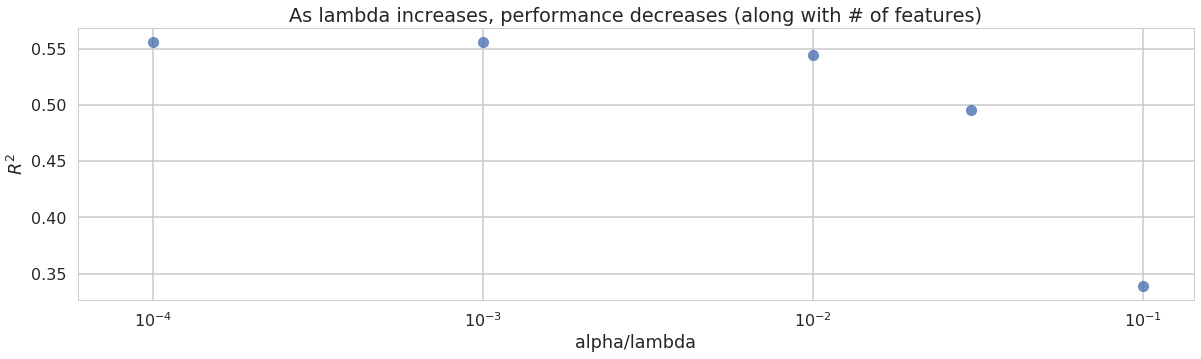

In [52]:
ax = sns.regplot(
    x=np.array([1e-1, 1e-2, 1e-3, 1e-4, 0.03]),
    y=np.array([0.338813, 0.544087, 0.555909, 0.556311, 0.495761]),
    fit_reg=False
)
ax.set_xlabel('alpha/lambda')
ax.set_ylabel('$R^2$')
ax.set_xscale('log')
ax.set_title('As lambda increases, performance decreases (along with # of features)');

Inspecting the above graph, I would set the "elbow" for the best parameter for alpha to be 0.01.

## Conclusion

The findings in the other ipynb for LassoCV represent the best model.

In [28]:
model.score(X_test, y_test)

0.54159918297330223

In [53]:
model.best_params_

{'lassocv__alphas': [0.03]}

How many coefficients go to 0?

In [25]:
pd.Series(model.best_estimator_.steps[-1][-1].coef_).describe()

count    252.000000
mean      -0.004569
std        0.049632
min       -0.363193
25%        0.000000
50%       -0.000000
75%        0.000000
max        0.145756
dtype: float64

In [28]:
len(X_train.columns[model.best_estimator_.steps[-1][-1].coef_ != 0])

53

In [29]:
len(X_train.columns[model.best_estimator_.steps[-1][-1].coef_ != 0])

115

In [30]:
len(X_train.columns)

252

About half at `α=0.01`.

Which don't go to ones?

In [27]:
sorted(list(X_train.columns[model.best_estimator_.steps[-1][-1].coef_ != 0]))

['Source_Citizens Connect App',
 'Source_Self Service',
 'TYPE_Abandoned Bicycle',
 'TYPE_Abandoned Building',
 'TYPE_Abandoned Vehicles',
 'TYPE_Animal Found',
 'TYPE_Animal Generic Request',
 'TYPE_Animal Lost',
 'TYPE_Bed Bugs',
 'TYPE_Bicycle Issues',
 'TYPE_Breathe Easy',
 'TYPE_Building Inspection Request',
 'TYPE_Call Log',
 'TYPE_Carbon Monoxide',
 'TYPE_Catchbasin',
 'TYPE_Checkin',
 'TYPE_Chronic Dampness/Mold',
 'TYPE_Construction Debris',
 'TYPE_Contractors Complaint',
 'TYPE_Cross Metering - Sub-Metering',
 'TYPE_Egress',
 'TYPE_Electrical',
 'TYPE_Empty Litter Basket',
 'TYPE_Equipment Repair',
 'TYPE_Exceeding Terms of Permit',
 'TYPE_General Comments For An Employee',
 'TYPE_General Comments For a Program or Policy',
 'TYPE_General Lighting Request',
 'TYPE_Graffiti Removal',
 'TYPE_Heat - Excessive  Insufficient',
 'TYPE_Highway Maintenance',
 'TYPE_Housing Discrimination Intake Form',
 'TYPE_Illegal Auto Body Shop',
 'TYPE_Illegal Dumping',
 'TYPE_Illegal Occupancy',


We will want to run a model with just the above features to find out which ones are statistically significant, but we get a sense here that these factors are likely to be signficant:

- when source is from the mobile app or desktop website
- neighborhoods of East Boston and the North End
- the number of issues in the workers' queue at the time

## Conclusion

We didn't get a better $R^2$, which makes sense, since we weren't in an overfit situation anyways when we tried this regularization parameter.

We did find subset our features and got somewhat of an indication which ones are more likely to be significantly correlated to completion time than others. We also avoided crazy predictions that would have affected our $R^2$, at least for this particular random seed.